# 1. Install Dependencies and Setup

In [10]:
!pip install tensorflow opencv-python matplotlib


[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [11]:
!pip list

Package                      Version
---------------------------- -----------
absl-py                      2.1.0
appnope                      0.1.4
asttokens                    3.0.0
astunparse                   1.6.3
certifi                      2024.8.30
charset-normalizer           3.4.0
comm                         0.2.2
contourpy                    1.3.1
cycler                       0.12.1
debugpy                      1.8.9
decorator                    5.1.1
exceptiongroup               1.2.2
executing                    2.1.0
flatbuffers                  24.3.25
fonttools                    4.55.2
gast                         0.6.0
google-pasta                 0.2.0
grpcio                       1.68.1
h5py                         3.12.1
idna                         3.10
ipykernel                    6.29.5
ipython                      8.30.0
jedi                         0.19.2
jupyter_client               8.6.3
jupyter_core                 5.7.2
keras                        3.7.0


In [13]:
!uname -m

arm64


In [40]:
import tensorflow as tf
import os

To prevent tensorflow from using up all the ram.

In [15]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [16]:
tf.config.list_physical_devices('GPU')

[]

# 2. Remove dodgy images

In [17]:
import cv2
import imghdr

In [18]:
data_dir = 'data' 

In [19]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [20]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

# 3. Load Data

In [21]:
import numpy as np
from matplotlib import pyplot as plt

In [22]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 305 files belonging to 2 classes.


In [23]:
data_iterator = data.as_numpy_iterator()

In [24]:
batch = data_iterator.next()

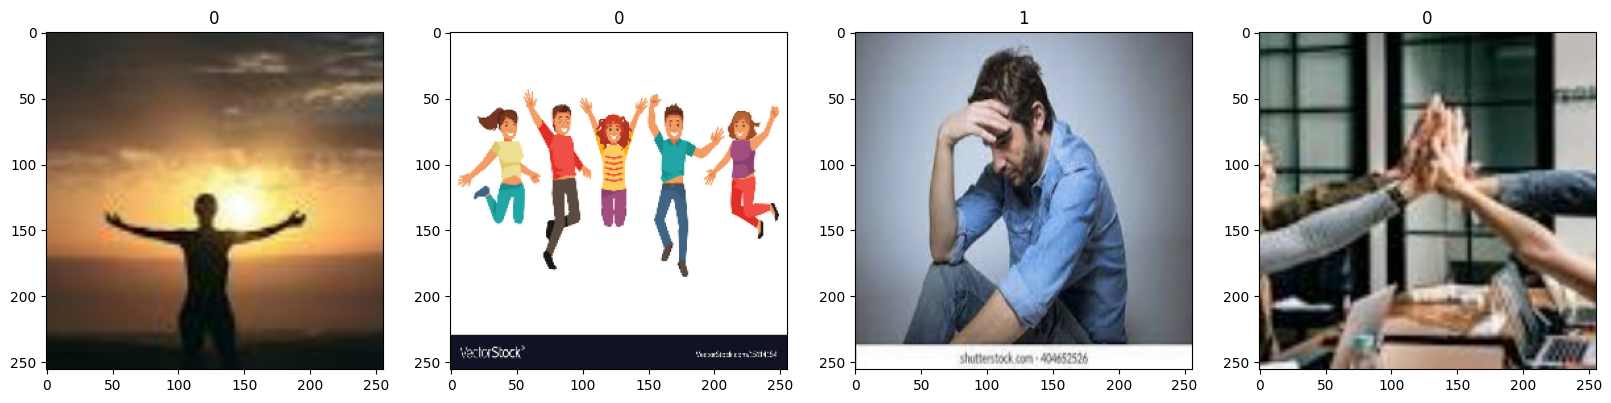

In [26]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 4. Scale Data

In [27]:
data = data.map(lambda x,y: (x/255, y))

In [28]:
data.as_numpy_iterator().next()

(array([[[[1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ],
          ...,
          [1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ]],
 
         [[1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ],
          ...,
          [1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ]],
 
         [[1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ],
          ...,
          [1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ]],
 
         ...,
 
         [[0.06666667, 0.07058824, 0.14117648],
          [0.06666

# 5. Split Data

In [29]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [30]:
train_size

7

In [31]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# 6. Build Deep Learning Model

In [32]:
train

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [34]:
model = Sequential()

In [35]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

/Users/mercy/ImageClassification/imageclassification1/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [36]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

# 7. Train

In [37]:
logdir='logs'

In [38]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [39]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 353ms/step - accuracy: 0.5369 - loss: 0.9497 - val_accuracy: 0.5625 - val_loss: 0.6423
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 340ms/step - accuracy: 0.6266 - loss: 0.6178 - val_accuracy: 0.8281 - val_loss: 0.5386
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 318ms/step - accuracy: 0.7756 - loss: 0.5411 - val_accuracy: 0.8594 - val_loss: 0.3823
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 321ms/step - accuracy: 0.8472 - loss: 0.4167 - val_accuracy: 0.9219 - val_loss: 0.2615
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 318ms/step - accuracy: 0.8547 - loss: 0.3506 - val_accuracy: 0.9531 - val_loss: 0.2326
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 453ms/step - accuracy: 0.9412 - loss: 0.2087 - val_accuracy: 1.0000 - val_loss: 0.1017
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 453ms/step - accuracy: 0.9478 - loss: 0.1592 - val_accuracy: 0.9688 - val_loss: 0.1295
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 355ms/step - accuracy: 0.9740 - loss: 0.1139 - val_accuracy: 0.9844 - val_loss:

# 8. Plot Performance

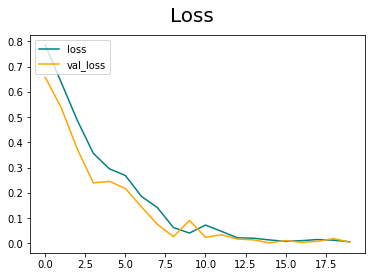

In [27]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

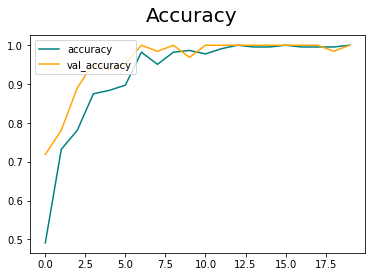

In [28]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 9. Evaluate

In [29]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [30]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [31]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

In [32]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32)


# 10. Test

In [33]:
import cv2

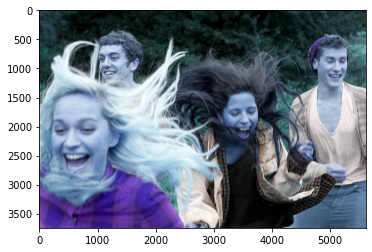

In [39]:
img = cv2.imread('154006829.jpg')
plt.imshow(img)
plt.show()

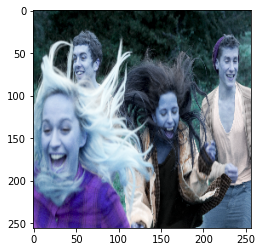

In [40]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [41]:
yhat = model.predict(np.expand_dims(resize/255, 0))

In [42]:
yhat

array([[0.01972741]], dtype=float32)

In [43]:
if yhat > 0.5: 
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')

Predicted class is Happy


# 11. Save the Model

In [44]:
from tensorflow.keras.models import load_model

In [45]:
model.save(os.path.join('models','imageclassifier.h5'))

In [46]:
new_model = load_model('imageclassifier.h5')

In [47]:
new_model.predict(np.expand_dims(resize/255, 0))

array([[0.01972741]], dtype=float32)